<a href="https://colab.research.google.com/github/avinayak/mona_lisa_gol_jax/blob/main/mona_lisa_overdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import jax
N=jax.numpy
L=jax.lax
from jax.experimental import loops
from jax import ops
import matplotlib.pyplot as plt
import numpy as onp
import time
from PIL import Image 
from google.colab import files

In [2]:
!wget -O target.png https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/483px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg?download

--2021-03-06 07:29:53--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/483px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg?download
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107820 (105K) [image/jpeg]
Saving to: ‘target.png’

target.png          100%[===================>] 105.29K  --.-KB/s    in 0.004s  

2021-03-06 07:29:53 (23.0 MB/s) - ‘target.png’ saved [107820/107820]



720 483
(50, 720, 483)


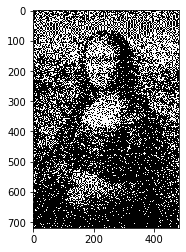

In [3]:
batch_size = 50
n_generations = 6

image_file = Image.open("target.png")
image_file = image_file.convert('1')
lisa = N.array(image_file, dtype=N.int32)
width,height = lisa.shape
print(width,height)
lisa_loaf = onp.repeat(lisa[onp.newaxis, :, :,], batch_size, axis = 0)
print(lisa_loaf.shape)

plt.imshow(lisa, interpolation="nearest", cmap = plt.cm.gray)

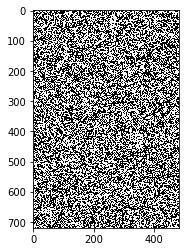

In [4]:
key = jax.random.PRNGKey(42)
canvas_loaf = jax.random.randint( key, (batch_size, width, height), 0, 2, dtype= N.int32)
plt.imshow(canvas_loaf[0], interpolation="nearest", cmap = plt.cm.gray)

In [5]:
@jax.jit
def rgen(a):
    # This reduction over-counts the neighbours of live cells since it includes the
    # central cell itself. Subtract out the array to correct for this.
    nghbrs=L.reduce_window(a, 0, L.add, (3,3), (1,1), "SAME")-a
    birth=N.logical_and(a==0, nghbrs==3)
    underpop=N.logical_and(a==1, nghbrs<2)
    overpop=N.logical_and(a==1, nghbrs>3)
    death=N.logical_or(underpop, overpop)

    na=L.select(birth,
                N.ones(a.shape, N.int32),
                a)

    na=L.select(death,
                N.zeros(a.shape, N.int32),
                na)
    return na

vectorized_rgen = jax.vmap(rgen)

@jax.jit
def nv_rgen(state):
  for _ in range(n_generations):
      state = vectorized_rgen(state)
  return state

def mutate_nj(b, w, h, subkey):
  a = jax.random.normal(subkey, (b, w, h))
  return (a == a.max(axis=(1,2))[:,None,None]).astype(int)

mutate = jax.jit(mutate_nj, static_argnums=(0,1,2))

def rmse_nj(original, canvas, b, w, h):
  return N.sqrt(N.mean(L.reshape((original-canvas)**2,(b,w*h)) , axis=1))

rmse = jax.jit(rmse_nj, static_argnums=(2,3,4))

def hill_climb(original, canvas, prng_key, iterations):
  with loops.Scope() as s:
    s.best_score = N.inf
    s.best_canvas = canvas
    s.canvas = canvas
    s.prng_key = prng_key
    for run in s.range(iterations):
      s.prng_key, subkey = jax.random.split(s.prng_key)
      s.canvas+=mutate(batch_size, width, height, subkey)
      s.canvas%=2
      rmse_vals = rmse(original, nv_rgen( s.canvas ), batch_size, width, height)
      curr_min = N.min(rmse_vals)
      for _ in s.cond_range(curr_min < s.best_score):
        s.best_score = curr_min
        s.best_canvas = N.repeat((s.canvas[N.argmin(rmse_vals)])[N.newaxis, :, :,], batch_size, axis = 0)
      s.canvas = s.best_canvas
    return s.canvas

0.6197264
0.6197264 0.49204624 20.602669 % Improvement
Elapsed 746.8979558944702


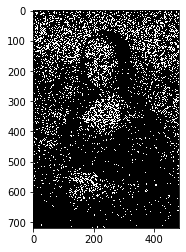

In [6]:
score_bef = N.min(rmse(lisa_loaf, nv_rgen(canvas_loaf)[0], batch_size, width, height))
print(score_bef)
sta = time.time()
result = hill_climb( lisa_loaf, canvas_loaf , key, 53000).block_until_ready()
sto = time.time()
score_af = N.min(rmse(lisa_loaf[0], nv_rgen(result)[0], 1, width, height))
print(score_bef, score_af, (score_bef - score_af)/score_bef*100 ,"% Improvement") #0.49599212 0.49540937 0.0005827546
print("Elapsed", sto - sta) #scount.block_until_ready()
plt.imshow(nv_rgen(result)[0], interpolation="nearest", cmap = plt.cm.gray)

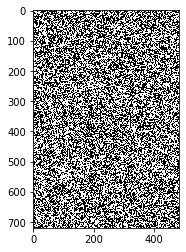

In [7]:
plt.imshow(result[0], interpolation="nearest", cmap = plt.cm.gray)

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

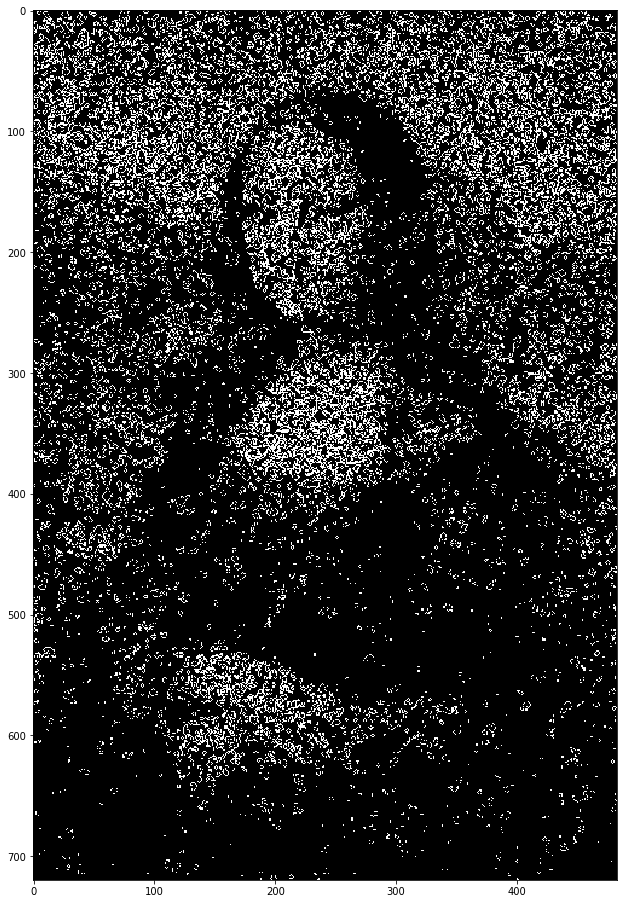

In [8]:
def create_movie(frames):
  fig = plt.figure(figsize=(16, 16))
  res_cop = N.array(result, copy=True)
  for frame in range(frames+15):
    plt.imshow(res_cop[0], interpolation="nearest", cmap = plt.cm.gray)
    plt.savefig(f'{str(frame).zfill(5)}.png', pad_inches=-1)
    if frame < frames:
      res_cop = vectorized_rgen(res_cop)

!rm -rf *.png
create_movie(n_generations)
!ffmpeg  -r 2 -f image2  -i %05d.png -vcodec libx264 -crf 25   -pix_fmt yuv420p lisa.mp4 -y
files.download('lisa.mp4')